In [2]:
# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Importing the training set
dataset= pd.read_csv("Datasets/SPX_Health_Sector_stocks_all.csv")

In [3]:
dataset['Date'] =  pd.to_datetime(dataset['Date'], infer_datetime_format=True)


In [4]:
dataset_train = dataset[dataset["Date"].isin(pd.date_range("2020-03-11", "2020-12-30"))]
dataset_train

,Ticker,Date,Open,High,Low,Close,Trading Volume,Volume Weighted Average Price,Number of Transactions
0,ABT,2020-03-11,73.28,78.15,72.0100,74.74,14123240.0,74.9395,113015
1,ABT,2020-03-12,77.91,82.67,74.8300,81.65,18521541.0,77.7958,160884
2,ABT,2020-03-15,70.65,79.25,70.0000,73.66,14358978.0,75.4936,113523
3,ABT,2020-03-16,75.52,79.79,73.3400,79.49,13441141.0,77.9694,124950
4,ABT,2020-03-17,74.98,81.99,74.3900,79.26,17680823.0,78.7228,141919
...,...,...,...,...,...,...,...,...,...
29878,BNTX,2020-12-23,98.50,99.89,96.6400,96.96,1039109.0,97.8215,14211
29879,BNTX,2020-12-27,95.00,95.40,87.0700,88.11,4698872.0,89.9943,58940
29880,BNTX,2020-12-28,84.45,89.39,83.8525,88.28,3300440.0,87.1904,35970
29881,BNTX,2020-12-29,90.00,90.89,83.0268,83.94,2941083.0,85.8906,35970


In [5]:
training_set = dataset_train.iloc[:, 2:3].values
training_set

array([[73.28],
       [77.91],
       [70.65],
       ...,
       [84.45],
       [90.  ],
       [83.38]])

In [6]:
# Feature Scaling
# Use Normalization (versus Standardization) for RNNs with Sigmoid Activation Functions
# 'MinMaxScalar' is a Normalization Library
from sklearn.preprocessing import MinMaxScaler
# 'feature_range = (0,1)' makes sure that training data is scaled to have values between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.05468372],
       [0.05854856],
       [0.05248836],
       ...,
       [0.06400775],
       [0.06864054],
       [0.06311458]])

In [6]:
# Creating a data structure with 60 timesteps (look back 60 days) and 1 output
# This tells the RNN what to remember (Number of timesteps) when predicting the next Stock Price
# The wrong number of timesteps can lead to Overfitting or bogus results
# 'x_train' Input with 60 previous days' stock prices
X_train = []
# 'y_train' Output with next day's stock price
y_train = []
for i in range(60, 13355):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [7]:
# Reshaping (add more dimensions)
# This lets you add more indicators that may potentially have corelation with Stock Prices
# Keras RNNs expects an input shape (Batch Size, Timesteps, input_dim)
# '.shape[0]' is the number of Rows (Batch Size)
# '.shape[1]' is the number of Columns (timesteps)
# 'input_dim' is the number of factors that may affect stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Show the dataset we're working with
display(dataset_train)

,Ticker,Date,Open,High,Low,Close,Trading Volume,Volume Weighted Average Price,Number of Transactions
0,ABT,2020-03-11,73.28,78.15,72.0100,74.74,14123240.0,74.9395,113015
1,ABT,2020-03-12,77.91,82.67,74.8300,81.65,18521541.0,77.7958,160884
2,ABT,2020-03-15,70.65,79.25,70.0000,73.66,14358978.0,75.4936,113523
3,ABT,2020-03-16,75.52,79.79,73.3400,79.49,13441141.0,77.9694,124950
4,ABT,2020-03-17,74.98,81.99,74.3900,79.26,17680823.0,78.7228,141919
...,...,...,...,...,...,...,...,...,...
29878,BNTX,2020-12-23,98.50,99.89,96.6400,96.96,1039109.0,97.8215,14211
29879,BNTX,2020-12-27,95.00,95.40,87.0700,88.11,4698872.0,89.9943,58940
29880,BNTX,2020-12-28,84.45,89.39,83.8525,88.28,3300440.0,87.1904,35970
29881,BNTX,2020-12-29,90.00,90.89,83.0268,83.94,2941083.0,85.8906,35970


In [8]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [9]:
# Initialising the RNN
# Regression is when you predict a continuous value
regressor = Sequential()

2022-01-31 22:45:58.086230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Adding the first LSTM layer and some Dropout regularisation
# 'units' is the number of LSTM Memory Cells (Neurons) for higher dimensionality
# 'return_sequences = True' because we will add more stacked LSTM Layers
# 'input_shape' of x_train
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# 20% of Neurons will be ignored (10 out of 50 Neurons) to prevent Overfitting
regressor.add(Dropout(0.2))

In [11]:
# Adding a second LSTM layer and some Dropout regularisation
# Not need to specify input_shape for second Layer, it knows that we have 50 Neurons from the previous layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# This is the last LSTM Layer. 'return_sequences = false' by default so we leave it out.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [12]:
# Adding the output layer
# 'units = 1' because Output layer has one dimension
regressor.add(Dense(units = 1))

# Compiling the RNN
# Keras documentation recommends 'RMSprop' as a good optimizer for RNNs
# Trial and error suggests that 'adam' optimizer is a good choice
# loss = 'mean_squared_error' which is good for Regression vs. 'Binary Cross Entropy' previously used for Classification
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# 'X_train' Independent variables
# 'y_train' Output Truths that we compare X_train to.
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
416/416 [==============================] - 32s 62ms/step - loss: 0.0027
Epoch 2/100
416/416 [==============================] - 25s 60ms/step - loss: 0.0014
Epoch 3/100
416/416 [==============================] - 25s 59ms/step - loss: 0.0012
Epoch 4/100
416/416 [==============================] - 25s 60ms/step - loss: 9.0680e-04
Epoch 5/100
416/416 [==============================] - 24s 58ms/step - loss: 8.8534e-04
Epoch 6/100
416/416 [==============================] - 23s 56ms/step - loss: 6.3963e-04
Epoch 7/100
416/416 [==============================] - 23s 56ms/step - loss: 7.8647e-04
Epoch 8/100
416/416 [==============================] - 23s 56ms/step - loss: 6.5414e-04
Epoch 9/100
416/416 [==============================] - 23s 56ms/step - loss: 5.9605e-04
Epoch 10/100
416/416 [==============================] - 24s 57ms/step - loss: 5.9551e-04
Epoch 11/100
416/416 [==============================] - 23s 56ms/step - loss: 5.3339e-04
Epoch 12/100
416/416 [====================

In [13]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2021
dataset = pd.read_csv("Datasets/SPX_Health_Sector_stocks_all.csv")

dataset['Date'] =  pd.to_datetime(dataset['Date'], infer_datetime_format=True)
dataset_test = dataset[dataset["Date"].isin(pd.date_range("2021-01-01", "2021-12-30"))]
real_stock_price = dataset_test.iloc[:, 2:3].values

In [14]:
# Getting the predicted stock price of 2021
# We need 60 previous inputs for each day of the Test_set in 2021
# Combine 'dataset_train' and 'dataset_test'
# 'axis = 0' for Vertical Concatenation to add rows to the bottom
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

In [15]:
# Extract Stock Prices for Test time period, plus 60 days previous
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# 'reshape' function to get it into a NumPy format
inputs = inputs.reshape(-1,1)
# Inputs need to be scaled to match the model trained on Scaled Feature
inputs = sc.transform(inputs)
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

for i in range(60, 16840):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)


In [16]:
# We need a 3D input so add another dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Predict the Stock Price
predicted_stock_price = regressor.predict(X_test)
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

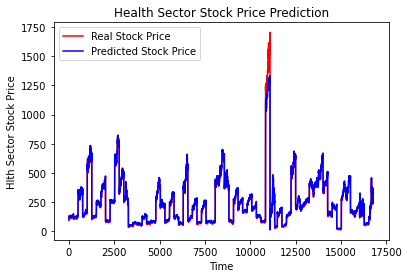

In [17]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Health Sector Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Hlth Sector Stock Price')
plt.legend()
plt.show()